In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from myconfig import ROOT_DIR, DATA_DIR, DATASET_DIR
from plotutil import *

In [2]:
%matplotlib inline

In [3]:
conditions = pd.read_csv(DATASET_DIR/'01-simulation01'/'conditions.tsv', sep='\t')

In [4]:
default = conditions.iloc[0]

cond_groups = {
    key: pd.concat([
        default.to_frame().T, 
        conditions[conditions[key] != default[key]]
    ]).sort_values(by=key)
    for key in ['lmax', 'ncat', 'ntips', 'nOGs']
}

In [5]:
best_recon_pcorrect = pd.read_csv(
    ROOT_DIR/'results'/'simulaton-recon-pcorrect.tsv', sep='\t', index_col=0
)

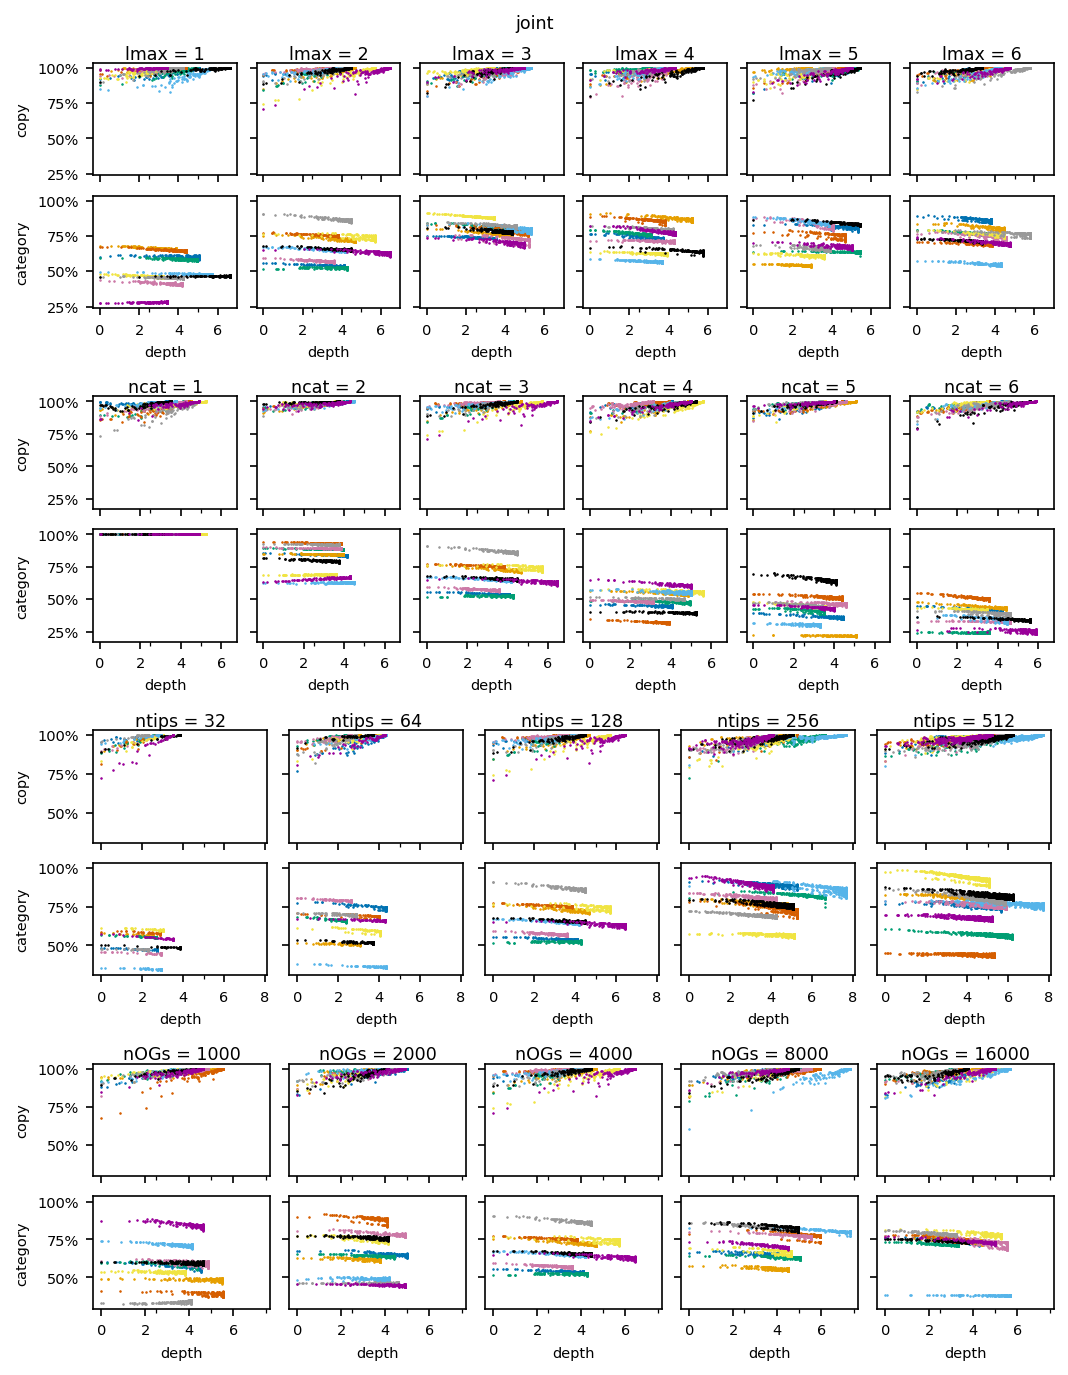

In [6]:
recon_grp = best_recon_pcorrect.groupby('conditionID')

with plt.rc_context({
    'font.size': 7, 
    'axes.prop_cycle': OkabeItoCUDcy.concat(plt.cycler(color=['#999999','#000000','#990099']))
}):
    for method in ('joint', 'marginal'):
        fig = plt.figure(layout='constrained', figsize=(178*mm, 230*mm), dpi=150)
        subfigs = fig.subfigures(len(cond_groups), wspace=0.07)

        for (key, conds), subfig in zip(cond_groups.items(), subfigs):
            axes = subfig.subplots(2, len(conds), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.0001))
            for (_, cond), ax in zip(conds.iterrows(), axes[0]):
                for rep, tmp in recon_grp.get_group(cond.conditionID).groupby('data_rep'):
                    tmp.plot.scatter(x='depth', y=f"('{method}', 'pcorrect_cpy')", s=0.5, lw=0.5, c=f'C{rep-1}', ax=ax)
                ax.set_ylabel('copy')
                ax.set_title(f'{key} = {cond[key]}', pad=0.1)

            for (_, cond), ax in zip(conds.iterrows(), axes[1]):
                for rep, tmp in recon_grp.get_group(cond.conditionID).groupby('data_rep'):
                    tmp.plot.scatter(x='depth', y=f"('{method}', 'pcorrect_cat')", s=0.5, lw=0.5, c=f'C{rep-1}', ax=ax)
                ax.set_ylabel('category')

            for ax in axes.flatten():
                ax.margins(0.05)
                ax.xaxis.set_major_locator(plt.MultipleLocator(2))
                ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
                ax.yaxis.set_major_formatter(PercentFormatter(1))
        
        fig.suptitle(method)
        
        display(fig)
        plt.close(fig)
        break

In [7]:
root_pcorrect = (
    best_recon_pcorrect[best_recon_pcorrect['node'].eq('i1')]
    .drop(columns=['loglik', 'depth'])
    .set_index(['conditionID','data_rep','fit_rep','lmax','ncat','ntips','nOGs','node'])
    .rename_axis(columns='kind')
    .stack()
    .rename('pct')
    .reset_index()
    .assign(
        method=lambda df: df['kind'].map({
            "('joint', 'pcorrect_cpy')"   : 'joint'   , 
            "('joint', 'pcorrect_cat')"   : 'joint'   , 
            "('marginal', 'pcorrect_cpy')": 'marginal', 
            "('marginal', 'pcorrect_cat')": 'marginal', 
        }), 
        state=lambda df: df['kind'].map({
            "('joint', 'pcorrect_cpy')"   : 'copy'    , 
            "('joint', 'pcorrect_cat')"   : 'category', 
            "('marginal', 'pcorrect_cpy')": 'copy'    , 
            "('marginal', 'pcorrect_cat')": 'category', 
        }), 
    ).drop(columns='kind')
)

root_pcorrect

,conditionID,data_rep,fit_rep,lmax,ncat,ntips,nOGs,node,pct,method,state
0,cond01,1,9,2,3,128,4000,i1,0.93875,joint,copy
1,cond01,1,9,2,3,128,4000,i1,0.55650,joint,category
2,cond01,1,9,2,3,128,4000,i1,0.94375,marginal,copy
3,cond01,1,9,2,3,128,4000,i1,0.65275,marginal,category
4,cond01,2,10,2,3,128,4000,i1,0.84875,joint,copy
...,...,...,...,...,...,...,...,...,...,...,...
755,cond19,9,3,6,3,128,4000,i1,0.85450,marginal,category
756,cond19,10,5,6,3,128,4000,i1,0.92375,joint,copy
757,cond19,10,5,6,3,128,4000,i1,0.73800,joint,category
758,cond19,10,5,6,3,128,4000,i1,0.92550,marginal,copy


In [8]:
leaf_pcorrect_median = (
    best_recon_pcorrect[best_recon_pcorrect['node'].str.startswith('t')]
    .drop(columns=['depth','loglik','node'])
    .groupby('conditionID data_rep fit_rep lmax ncat ntips nOGs'.split(), as_index=False)
    .median()
    .set_index(['conditionID','data_rep','fit_rep','lmax','ncat','ntips','nOGs'])
    .rename_axis(columns='kind')
    .stack()
    .rename('pct')
    .reset_index()
    .assign(
        method=lambda df: df['kind'].map({
            "('joint', 'pcorrect_cpy')"   : 'joint'   , 
            "('joint', 'pcorrect_cat')"   : 'joint'   , 
            "('marginal', 'pcorrect_cpy')": 'marginal', 
            "('marginal', 'pcorrect_cat')": 'marginal', 
        }), 
        state=lambda df: df['kind'].map({
            "('joint', 'pcorrect_cpy')"   : 'copy'    , 
            "('joint', 'pcorrect_cat')"   : 'category', 
            "('marginal', 'pcorrect_cpy')": 'copy'    , 
            "('marginal', 'pcorrect_cat')": 'category', 
        }), 
    ).drop(columns='kind')
)

In [9]:
panel_cols = ['lmax', 'ncat', 'ntips', 'nOGs']

xlabels = dict(
    lmax  = '$l_\mathrm{max}$ (max copy)', 
    ncat  = '$K$ (#categories)', 
    nOGs  = '$N$ (#OGs)', 
    ntips = '$D$ (#tips)', 
)

In [10]:
def plot_recon_perf(df, state):
    with plt.rc_context({'font.size': 7}):
        fig, axes = plt.subplots(
            1, len(panel_cols), sharex='col', sharey=True, 
            dpi=300, figsize=(178*mm, 65*mm), layout='tight'
        )
        for idx, (key, ax) in enumerate(zip(panel_cols, axes)):
            cond_grp = cond_groups[key]

            data = df[
                df['conditionID'].isin(cond_grp['conditionID']) & 
                df['state'].eq(state)
            ]
            
            sns.stripplot(
                data=data, x=key, y='pct', order=cond_grp[key], 
                hue='method', hue_order=['joint', 'marginal'], dodge=True, jitter=0, 
                marker='D', palette='blend:#0072B2,#0072B2', edgecolor='w', linewidth=0.2, alpha=0.75, size=2, 
                legend=False, ax=ax
            )
            sns.boxplot(
                data, x=key, y='pct', order=cond_grp[key], 
                hue='method', hue_order=['joint', 'marginal'], palette='Greys', 
                linewidth=0.5, fliersize=0, ax=ax
            )
            hanlab = ax.get_legend_handles_labels()
            ax.legend().remove()

            dx = cond_grp[key].to_list().index(default[key])
            ax.axvspan(dx-0.5, dx+0.5, alpha=0.1, fc='#0072B2')
            
            ax.set_xlabel(xlabels[key], visible=True)
            ax.set_ylabel('correct reconstruction', visible=True, labelpad=0.3)
            #ax.set_ylabel('correct reconstruction')
            ax.xaxis.set_tick_params(labelbottom=True)
            ax.yaxis.set_tick_params(labelleft=True, pad=0.1)
            ax.yaxis.grid()
            ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
            ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
            if key == 'nOGs':
                ax.set_xticklabels(cond_grp[key].astype(str).str.replace('000', 'K'))
                
            ax.text(-0.39, 1.03, chr(ord('A')+idx), fontsize='xx-large', transform=ax.transAxes)
        fig.legend(*hanlab, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
        fig.align_ylabels()
        
    return fig

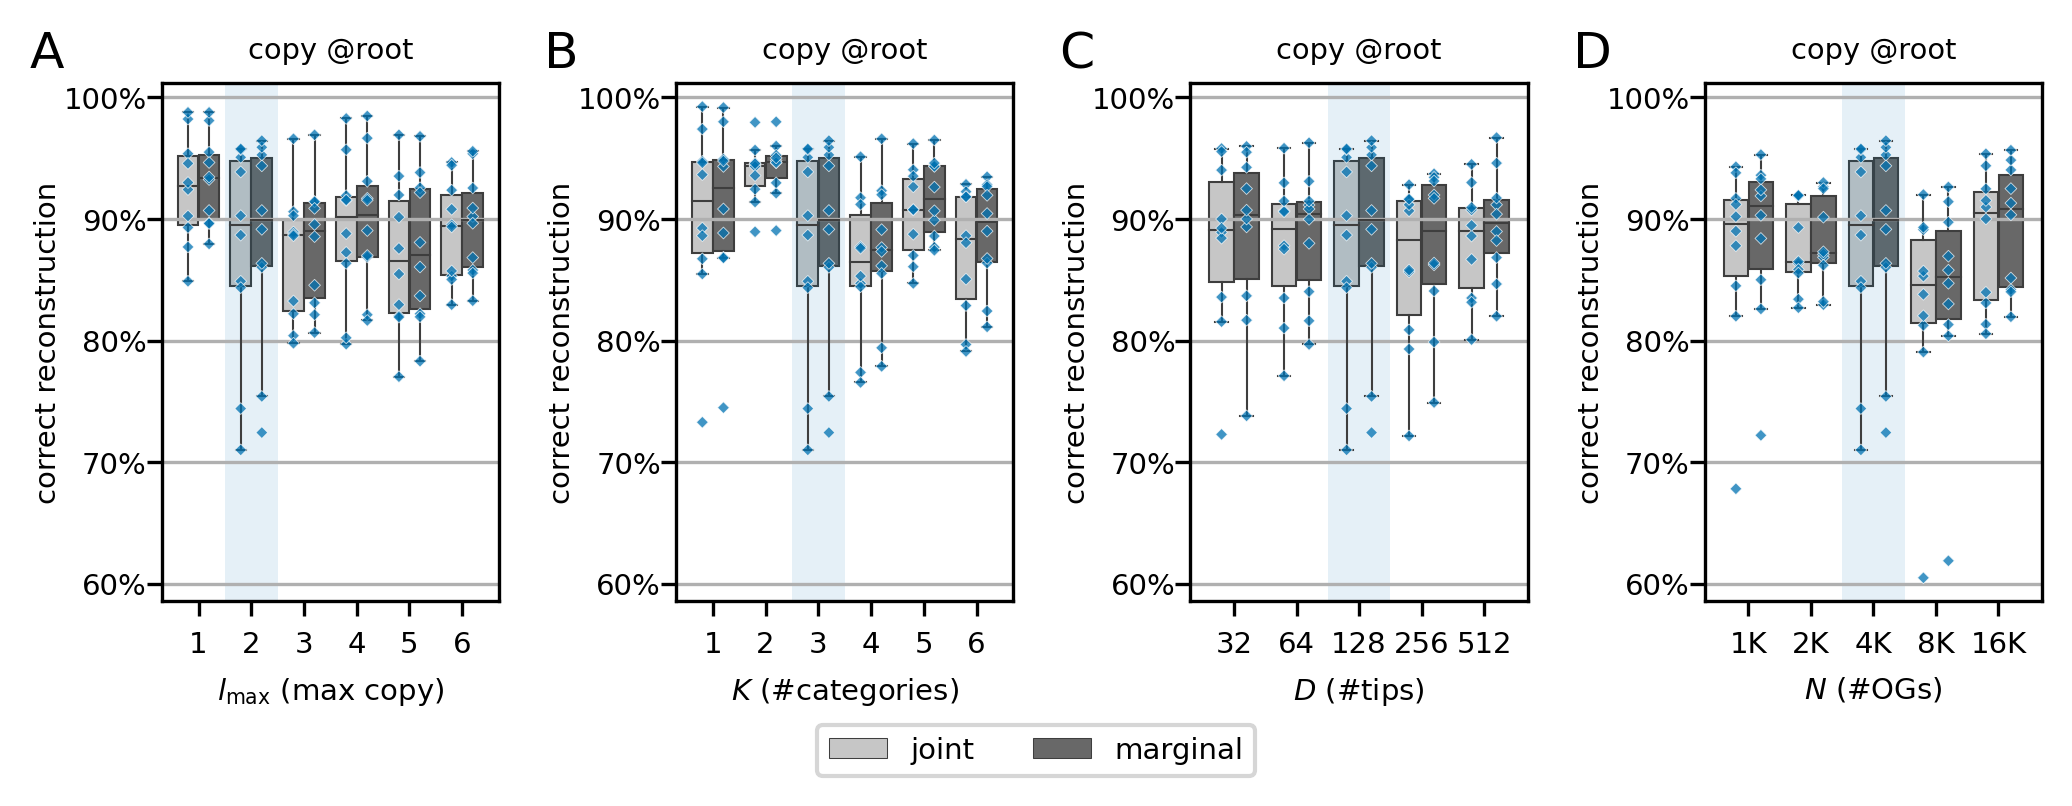

In [11]:
fig = plot_recon_perf(root_pcorrect, 'copy')
for ax in fig.axes:
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.set_title('copy @root', fontsize='x-small')
    
fig.savefig('jpg/accuracy-recon-rtcopy.jpg', bbox_inches='tight', dpi=350)
fig.savefig('png/accuracy-recon-rtcopy.png', bbox_inches='tight', dpi=350)
fig.savefig('pdf/accuracy-recon-rtcopy.pdf', bbox_inches='tight')

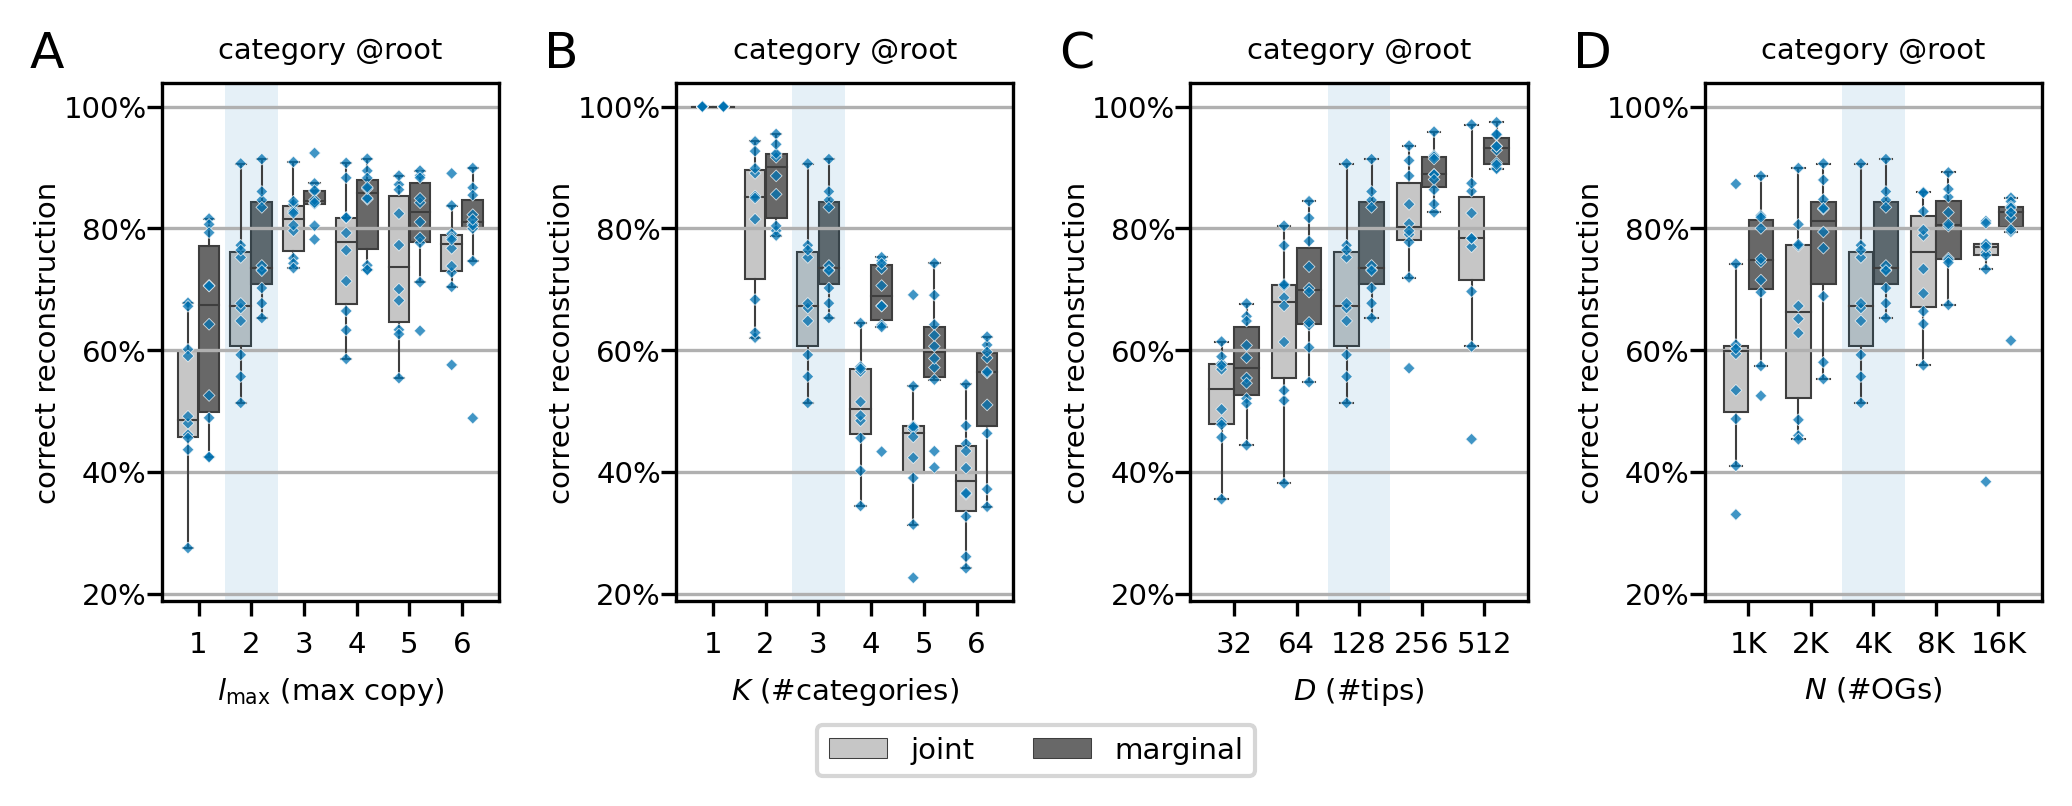

In [12]:
fig = plot_recon_perf(root_pcorrect, 'category')
for ax in fig.axes:
    ax.set_title('category @root', fontsize='x-small')
    
fig.savefig('jpg/accuracy-recon-rtcat.jpg', bbox_inches='tight', dpi=350)
fig.savefig('png/accuracy-recon-rtcat.png', bbox_inches='tight', dpi=350)
fig.savefig('pdf/accuracy-recon-rtcat.pdf', bbox_inches='tight')

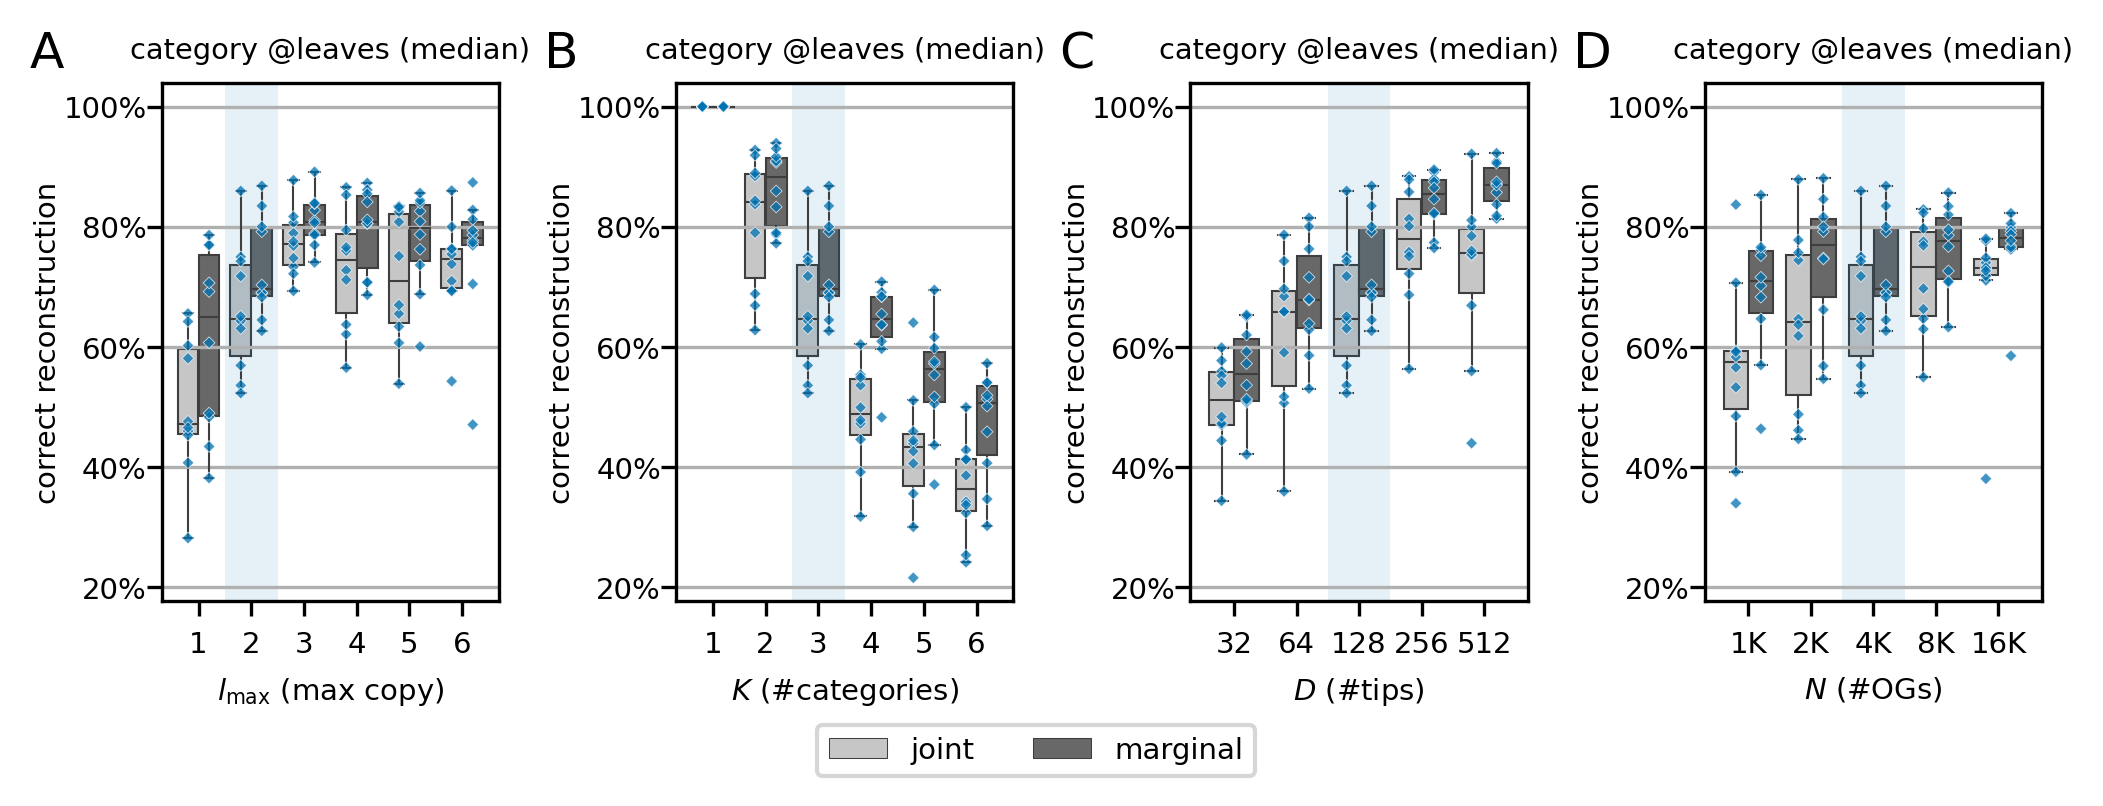

In [13]:
fig = plot_recon_perf(leaf_pcorrect_median, 'category')
for ax in fig.axes:
    ax.set_title('category @leaves (median)', fontsize='x-small')
    
fig.savefig('jpg/accuracy-recon-lfcat.jpg', bbox_inches='tight', dpi=350)
fig.savefig('png/accuracy-recon-lfcat.png', bbox_inches='tight', dpi=350)
fig.savefig('pdf/accuracy-recon-lfcat.pdf', bbox_inches='tight')